<a href="https://colab.research.google.com/github/milanzongor/fault_detection_project/blob/master/fault_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sensor fault detection using machine learning

##Assignment
**47 Detekce poruch senzorů pomocí strojového učení B**

Navrhněte metodu pro detekci poruch senzorů (drift, offset, občasné
vychýlené hodnoty) s využitím dodaných dlouhých časových řad dat z
různých senzorů rodinného domu.

Data stáhněte z:
https://drive.google.com/drive/u/1/folders/1NuBf9n8XOYr_wH1IdUJoKNnhUJUvndSD

Označení sloupců rozkódujte pomocí možného významu dle přiloženého
souboru TXT. Prověřte, zda data neobsahují "impulsní" extrémní hodnoty,
výpadky a NaN, pokud ano, vyřaďte je nebo interpolujte. Jinak považujte
data za správná, tj. bez driftu a offsetu.

Můžete využít typické časové chování sinálů i vztahy mezi různými signály.

##Data description
House 11 is located in San Antonio, Texas. The measurements from this house include:

**Water heater performance**:
 Electricity use, temperature and volume of cold water entering, temperature and volume of hot water supplied by the water heater

 water_heater_electricity use of cold water
 water_heater_temp_cold - T_DHW_H_AVG
 water_heater_volume_cold

 water_heater_temp_hot - T_DHW_C_AVG
 water_heater_volume_hot

**HVAC system performance**:
 Furnace natural gas use, air conditioner outdoor unit compressor and fan electricity use, air handler unit fan electricity use, temperature and RH at first and second floor thermostats, temperature and RH of outdoor air.

 furnace_gas_use - G_FURNACE_TOT
 ACU_outdoor_el_usage
 AHU_air_handler_fan_electricity - kWh_AHU 
 termostat_temp_1st - T_1ST_AVG
 termostat_rh_1st - RH_1ST_AVG
 termostat_temp_2nd - T_2ND_AVG
 termostat_rh_2nd - RH_2ND_AVG
 temp_out - T_Out_AVG
 rh_out - RH_Out_AVG

**Photovoltaic array performance**:
 Electricity produced, electricity sold, incident solar radiation on the on the photovoltaic array

 photo_el_produced
 photo_el_sold
 photo_solar_radiation - R_SOLAR_AVG

 iné v pracovné dni ako cez víkend, periodicky cez deň-týždeň, korelácie medzi veličinami. prvá úloha - aké sú typické vzorce chovania, data použiť pre strojové účenie LSTM,

 nájsť aj kratkodobé aj dlhodobé chovanie
 uvazovat iba jeden typ poruchy pre jeden typ senzoru

 prvý krok zobraziť hodnoty, napr aj scatter diagramy, histogramy, priemery atď
 
 vybrať si určité veličiny

 adaptovať GRU, LSTM sieť v vhodným prepo - tu sa klasifikuje sekvencia

 stačí iba rozlíšenie či je hodnota v pohode alebo nie

 stúpajúci úsek, klesajúci úsek - diskretizovať

 armax, ARG model, predvídať sekvenciu - možnosť
 

##Coding part

In [15]:
# imports
import pandas as pd
import numpy as np
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Loading dataset

In [16]:
df_raw = pd.read_csv("/content/drive/My Drive/School/B3B38DIT/House_11_edit.csv")

# print information about dataset and show the first 5 rows
print(df_raw.info())
display(df_raw.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year_RTM           3810 non-null   int64  
 1   Day_RTM            3810 non-null   int64  
 2   Hour_Minute_RTM    3810 non-null   int64  
 3   Datetime           3810 non-null   object 
 4   PrgSig             3810 non-null   int64  
 5   VBatt              3810 non-null   float64
 6   Year_RTM.1         3810 non-null   int64  
 7   Day_RTM.1          3810 non-null   int64  
 8   Hour_Minute_RTM.1  3810 non-null   int64  
 9   PrgSig.1           3810 non-null   int64  
 10  VBatt.1            3810 non-null   float64
 11  R_SOLAR_AVG        3810 non-null   float64
 12  T_Out_AVG          3810 non-null   float64
 13  T_1ST_AVG          3810 non-null   float64
 14  T_2ND_AVG          3810 non-null   float64
 15  T_DHW_C_AVG        2779 non-null   float64
 16  T_DHW_H_AVG        2779 

,Year_RTM,Day_RTM,Hour_Minute_RTM,Datetime,PrgSig,VBatt,Year_RTM.1,Day_RTM.1,Hour_Minute_RTM.1,PrgSig.1,VBatt.1,R_SOLAR_AVG,T_Out_AVG,T_1ST_AVG,T_2ND_AVG,T_DHW_C_AVG,T_DHW_H_AVG,RH_Out_AVG,RH_1ST_AVG,RH_2ND_AVG,I_DHWa_AVG,I_DHWb_AVG,I_Solpmp_AVG,I_FirePl_AVG,RT_AHU_AVG,RT_CMP_AVG,kWh_DHWa_TOT,kWh_DHWb_TOT,WH_AHU_TOT,KWH_CMP_TOT,KWH_TANK_TOT,WH_SPMP_TOT,KWH_AMEL_TOT,KWH_Light_TOT,KWH_PV_P_TOT,KWH_PV_S_TOT,KWH_NET_TOT,KWH_HOUSE_TOT,Q_DWH_FSH_TOT,G_FURNACE_TOT,TE_DHWtnk_TOT,kWh_AHU
0,2010,196,1300,7/15/2010 13:00,5268,13.25,2010,196,1300,5268,13.25,555.9,86.8,75.1,75.0,NaN,NaN,59.83,37.94,41.50,17.550,17.620,0.339,0.007,1.0,1.0,0.392,0.393,17.58,0.299,0.785,0,0,0.231,0.0,0.0,1.458,1.458,0.0,0,0.0,0.01758
1,2010,196,1400,7/15/2010 14:00,5268,13.25,2010,196,1400,5268,13.25,-6999.0,88.4,75.0,75.3,NaN,NaN,55.66,37.20,40.34,11.500,11.530,0.339,0.007,1.0,1.0,1.379,1.384,98.40,1.587,2.763,0,0,1.447,0.0,0.0,6.358,6.358,0.0,0,0.0,0.09840
2,2010,196,1500,7/15/2010 15:00,5268,13.25,2010,196,1500,5268,13.25,-6999.0,91.6,74.9,75.0,NaN,NaN,49.15,36.26,38.97,0.009,0.022,0.331,0.008,1.0,1.0,0.001,0.003,226.70,2.405,0.004,0,0,1.359,0.0,0.0,4.253,4.253,0.0,0,0.0,0.22670
3,2010,196,1600,7/15/2010 16:00,5268,13.24,2010,196,1600,5268,13.24,701.0,92.7,74.8,75.1,NaN,NaN,46.31,35.37,39.24,0.013,0.027,0.326,0.008,1.0,1.0,0.002,0.003,243.00,2.496,0.005,0,0,1.322,0.0,0.0,4.310,4.310,0.0,0,0.0,0.24300
4,2010,196,1700,7/15/2010 17:00,5268,13.24,2010,196,1700,5268,13.24,615.4,93.5,75.0,75.0,NaN,NaN,44.00,35.85,38.86,0.013,0.027,0.321,0.008,1.0,1.0,0.002,0.003,227.30,2.502,0.005,0,0,1.333,0.0,0.0,4.303,4.303,0.0,0,0.0,0.22730


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year_RTM           3810 non-null   int64  
 1   Day_RTM            3810 non-null   int64  
 2   Hour_Minute_RTM    3810 non-null   int64  
 3   Datetime           3810 non-null   object 
 4   PrgSig             3810 non-null   int64  
 5   VBatt              3810 non-null   float64
 6   Year_RTM.1         3810 non-null   int64  
 7   Day_RTM.1          3810 non-null   int64  
 8   Hour_Minute_RTM.1  3810 non-null   int64  
 9   PrgSig.1           3810 non-null   int64  
 10  VBatt.1            3810 non-null   float64
 11  R_SOLAR_AVG        3810 non-null   float64
 12  T_Out_AVG          3810 non-null   float64
 13  T_1ST_AVG          3810 non-null   float64
 14  T_2ND_AVG          3810 non-null   float64
 15  T_DHW_C_AVG        2779 non-null   float64
 16  T_DHW_H_AVG        2779 

,Year_RTM,Day_RTM,Hour_Minute_RTM,Datetime,PrgSig,VBatt,Year_RTM.1,Day_RTM.1,Hour_Minute_RTM.1,PrgSig.1,VBatt.1,R_SOLAR_AVG,T_Out_AVG,T_1ST_AVG,T_2ND_AVG,T_DHW_C_AVG,T_DHW_H_AVG,RH_Out_AVG,RH_1ST_AVG,RH_2ND_AVG,I_DHWa_AVG,I_DHWb_AVG,I_Solpmp_AVG,I_FirePl_AVG,RT_AHU_AVG,RT_CMP_AVG,kWh_DHWa_TOT,kWh_DHWb_TOT,WH_AHU_TOT,KWH_CMP_TOT,KWH_TANK_TOT,WH_SPMP_TOT,KWH_AMEL_TOT,KWH_Light_TOT,KWH_PV_P_TOT,KWH_PV_S_TOT,KWH_NET_TOT,KWH_HOUSE_TOT,Q_DWH_FSH_TOT,G_FURNACE_TOT,TE_DHWtnk_TOT,kWh_AHU
0,2010,196,1300,7/15/2010 13:00,5268,13.25,2010,196,1300,5268,13.25,555.9,86.8,75.1,75.0,NaN,NaN,59.83,37.94,41.50,17.550,17.620,0.339,0.007,1.0,1.0,0.392,0.393,17.58,0.299,0.785,0,0,0.231,0.0,0.0,1.458,1.458,0.0,0,0.0,0.01758
1,2010,196,1400,7/15/2010 14:00,5268,13.25,2010,196,1400,5268,13.25,-6999.0,88.4,75.0,75.3,NaN,NaN,55.66,37.20,40.34,11.500,11.530,0.339,0.007,1.0,1.0,1.379,1.384,98.40,1.587,2.763,0,0,1.447,0.0,0.0,6.358,6.358,0.0,0,0.0,0.09840
2,2010,196,1500,7/15/2010 15:00,5268,13.25,2010,196,1500,5268,13.25,-6999.0,91.6,74.9,75.0,NaN,NaN,49.15,36.26,38.97,0.009,0.022,0.331,0.008,1.0,1.0,0.001,0.003,226.70,2.405,0.004,0,0,1.359,0.0,0.0,4.253,4.253,0.0,0,0.0,0.22670
3,2010,196,1600,7/15/2010 16:00,5268,13.24,2010,196,1600,5268,13.24,701.0,92.7,74.8,75.1,NaN,NaN,46.31,35.37,39.24,0.013,0.027,0.326,0.008,1.0,1.0,0.002,0.003,243.00,2.496,0.005,0,0,1.322,0.0,0.0,4.310,4.310,0.0,0,0.0,0.24300
4,2010,196,1700,7/15/2010 17:00,5268,13.24,2010,196,1700,5268,13.24,615.4,93.5,75.0,75.0,NaN,NaN,44.00,35.85,38.86,0.013,0.027,0.321,0.008,1.0,1.0,0.002,0.003,227.30,2.502,0.005,0,0,1.333,0.0,0.0,4.303,4.303,0.0,0,0.0,0.22730


###Data cleaning


####Unnecessary data

#####Uninformative / Repetitive
Finding the rows, which has low information value or are highly repetitive.
If the feature has more than 95% of the rows the same, highlight it.

In [17]:
num_rows = len(df_raw.index)
low_information_cols = [] #

for col in df_raw.columns:
    cnts = df_raw[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Year_RTM: 100.00000%
2010    3810
Name: Year_RTM, dtype: int64

Year_RTM.1: 100.00000%
2010    3810
Name: Year_RTM.1, dtype: int64

WH_SPMP_TOT: 100.00000%
0    3810
Name: WH_SPMP_TOT, dtype: int64

KWH_AMEL_TOT: 100.00000%
0    3810
Name: KWH_AMEL_TOT, dtype: int64

G_FURNACE_TOT: 97.74278%
0     3724
22       8
24       7
26       6
23       6
25       5
21       5
13       4
8        4
9        4
17       3
28       3
29       3
4        2
12       2
19       2
35       2
30       2
27       2
20       2
18       2
14       2
6        1
10       1
2        1
69       1
1        1
5        1
7        1
15       1
33       1
32       1
Name: G_FURNACE_TOT, dtype: int64

Year_RTM: 100.00000%
2010    3810
Name: Year_RTM, dtype: int64

Year_RTM.1: 100.00000%
2010    3810
Name: Year_RTM.1, dtype: int64

WH_SPMP_TOT: 100.00000%
0    3810
Name: WH_SPMP_TOT, dtype: int64

KWH_AMEL_TOT: 100.00000%
0    3810
Name: KWH_AMEL_TOT, dtype: int64

G_FURNACE_TOT: 97.74278%
0     3724
22       8
24   

#####Drop data
I am going to remove the unnecessary columns. In this task I decided to do the analysis with the temperature and relative humidity data. That is why I am going to drop other columns from dataset. I am going to remove the repetitive, duplicated and unnecessary columns.

In [39]:
columns_to_keep = ['Datetime', 'T_Out_AVG', 'T_1ST_AVG', 'T_2ND_AVG', 'RH_1ST_AVG', 'RH_2ND_AVG']
df = df_raw[columns_to_keep]
df.head(5)

,Datetime,T_Out_AVG,T_1ST_AVG,T_2ND_AVG,RH_1ST_AVG,RH_2ND_AVG
0,7/15/2010 13:00,86.8,75.1,75.0,37.94,41.50
1,7/15/2010 14:00,88.4,75.0,75.3,37.20,40.34
2,7/15/2010 15:00,91.6,74.9,75.0,36.26,38.97
3,7/15/2010 16:00,92.7,74.8,75.1,35.37,39.24
4,7/15/2010 17:00,93.5,75.0,75.0,35.85,38.86


####Missing data
In this section I am going to check if our dataset contains some missing values (null).

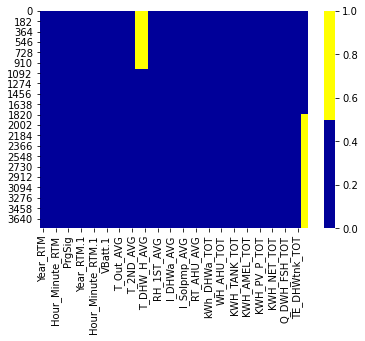

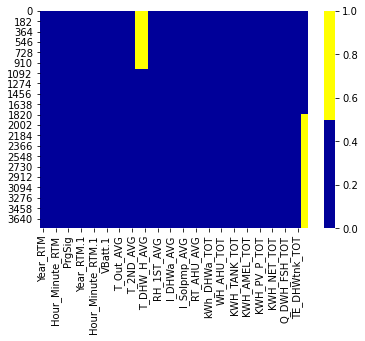

In [19]:
cols = df_raw.columns[:]
colours = ['#000099', '#ffff00'] # yellow is missing. blue is not missing.
sns.heatmap(df_raw[cols].isnull(), cmap=sns.color_palette(colours))

In [20]:
# Count of null cells in each column for the small dataset
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))
print(df.shape)

Number of null values in each column:
Datetime      0
T_Out_AVG     0
T_1ST_AVG     0
T_2ND_AVG     0
RH_1ST_AVG    0
RH_2ND_AVG    0
dtype: int64
(3810, 6)
Number of null values in each column:
Datetime      0
T_Out_AVG     0
T_1ST_AVG     0
T_2ND_AVG     0
RH_1ST_AVG    0
RH_2ND_AVG    0
dtype: int64
(3810, 6)


In [21]:
df.dtypes

Datetime       object
T_Out_AVG     float64
T_1ST_AVG     float64
T_2ND_AVG     float64
RH_1ST_AVG    float64
RH_2ND_AVG    float64
dtype: object

Datetime       object
T_Out_AVG     float64
T_1ST_AVG     float64
T_2ND_AVG     float64
RH_1ST_AVG    float64
RH_2ND_AVG    float64
dtype: object

####Irregular data (outliers)


#####Histogram/Box Plot

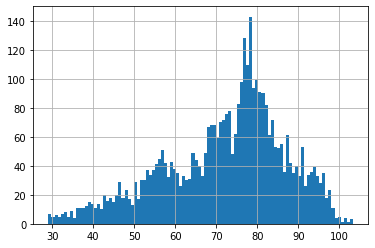

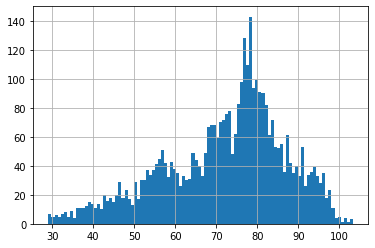

In [22]:
df['T_Out_AVG'].hist(bins=100)

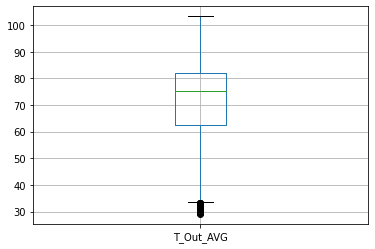

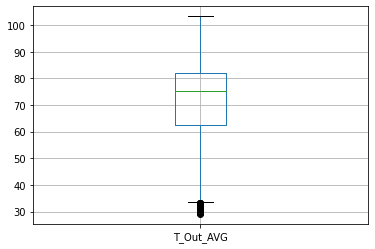

In [23]:
df.boxplot(column=['T_Out_AVG'])

#####Descriptive Statistics

In [24]:
df['T_Out_AVG'].describe()

count    3810.000000
mean       72.016194
std        14.880829
min        29.090000
25%        62.480000
50%        75.200000
75%        81.975000
max       103.300000
Name: T_Out_AVG, dtype: float64

count    3810.000000
mean       72.016194
std        14.880829
min        29.090000
25%        62.480000
50%        75.200000
75%        81.975000
max       103.300000
Name: T_Out_AVG, dtype: float64

####Inconsistent data
It is also crucial to have the dataset follow specific standards to fit a model.

#####Format inconsistency
I need to perform a standardization of the data formats. All our features, except datetime, are in float format. The float format makes sence for the temperature and RH values. The datetime feature has object value - it's format was not recognized by pandas. So I need to perform the transformation to datetime format.

In [25]:
print("Formats of dataset features")
df.dtypes

Formats of dataset features


Datetime       object
T_Out_AVG     float64
T_1ST_AVG     float64
T_2ND_AVG     float64
RH_1ST_AVG    float64
RH_2ND_AVG    float64
dtype: object

Formats of dataset features


Datetime       object
T_Out_AVG     float64
T_1ST_AVG     float64
T_2ND_AVG     float64
RH_1ST_AVG    float64
RH_2ND_AVG    float64
dtype: object

In [26]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

# dt = df.loc[1, "Datetime"]
# print(dt.month, dt.year, dt.day, dt.hour, dt.minute, dt.second)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
print("Formats of dataset features")
df.dtypes

Formats of dataset features


Datetime      datetime64[ns]
T_Out_AVG            float64
T_1ST_AVG            float64
T_2ND_AVG            float64
RH_1ST_AVG           float64
RH_2ND_AVG           float64
dtype: object

Formats of dataset features


Datetime      datetime64[ns]
T_Out_AVG            float64
T_1ST_AVG            float64
T_2ND_AVG            float64
RH_1ST_AVG           float64
RH_2ND_AVG           float64
dtype: object

####Plot check

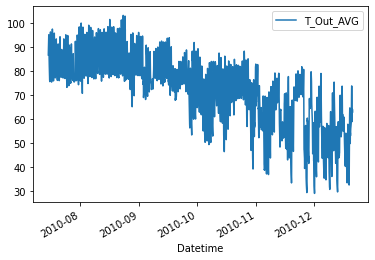

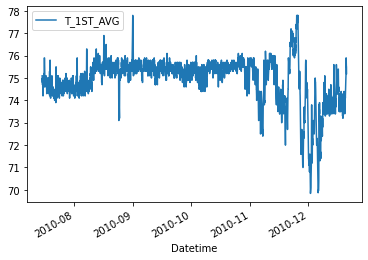

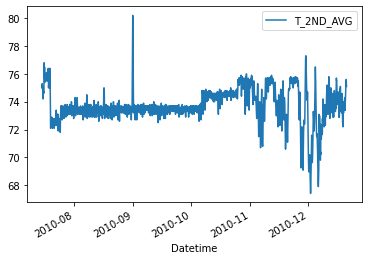

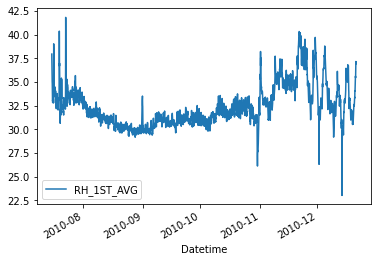

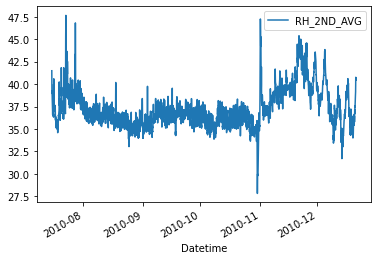

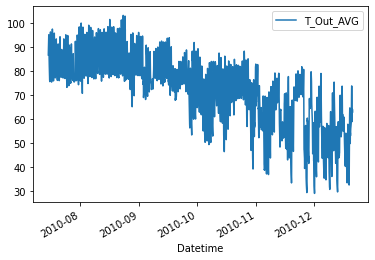

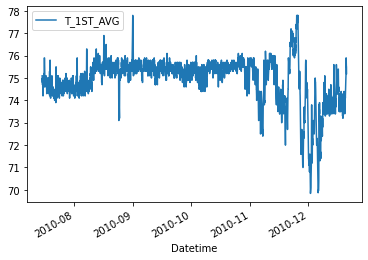

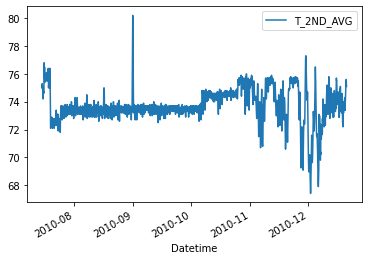

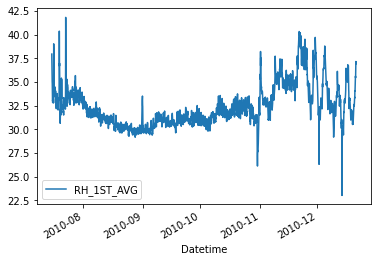

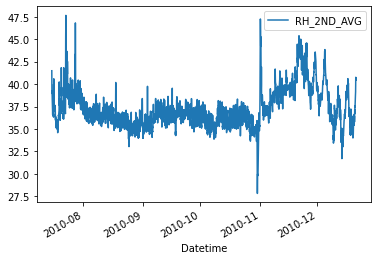

In [28]:
for feature in df.columns:
  if feature != 'Datetime':
    df.plot(x="Datetime", y=feature)

In [34]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df["T_2ND_AVG"]))
print(z)

threshold = 3
print(np.where(z > 3))

print(z[1133])

[1.0585559  1.30645618 1.0585559  ... 1.30645618 1.22382275 1.14118932]
(array([1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 3237, 3238, 3239,
       3240, 3241, 3242, 3243, 3260, 3261, 3262, 3263, 3264, 3265, 3266,
       3267, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342,
       3343, 3344, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356,
       3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367,
       3368, 3379, 3380, 3381, 3382, 3383, 3384, 3448, 3449, 3450, 3451,
       3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462,
       3477, 3481, 3482]),)
4.198626148101019


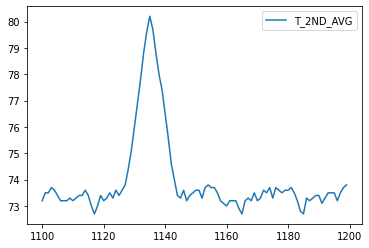

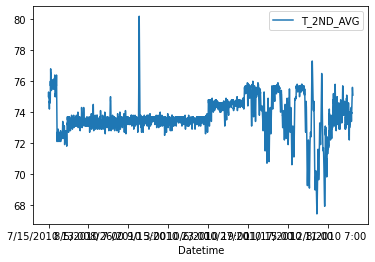

In [46]:
df.iloc[1100:1200].plot(y='T_2ND_AVG')
df.plot(x="Datetime", y='T_2ND_AVG')


In [0]:
feature = "T_2ND_AVG"

df.plot(x="Datetime", y=feature)

median = df[feature].mean()
std = df[feature].std()
outliers = (df[feature] - median).abs() > std
df[outliers] = np.nan
df[feature].fillna(median, inplace=True)

df.plot(x="Datetime", y=feature)

##Sources
[Weather station analysis](https://www.shanelynn.ie/analysis-of-weather-data-using-pandas-python-and-seaborn/)

[Data clening guide](https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d)

[Removing outlayers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)